In [24]:
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [20]:
# setting model&fmix path
package_paths = [
    './efficientnet_pytorch-0.7.0', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    './FMix-master']

import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
# 새로 설치한 파이토치 버전에서는 파일이름이 autocast_mode로 바뀐것 같다.
# import torch.cuda.amp.autocast_mode


'''
Is there some reason why you performed scaler.step(optimizer) inside with autocast()? 
I read in tutorials that it is not recommended to perform the backward pass inside the with autocast() (mentioned here).



Everything after and including scaler.scale(loss).backward() should come outside with autocast():, and that should be correct.
'''

'\nIs there some reason why you performed scaler.step(optimizer) inside with autocast()? \nI read in tutorials that it is not recommended to perform the backward pass inside the with autocast() (mentioned here).\n'

In [3]:
import timm  # timm 모듈은 다른 거랑 임포트를 같이 못쓰는듯??이상하네

In [6]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp.autocast_mode import autocast# 표현이 틀린것 같아서 대충 때려 박앗더니 됨. 변경전 : from torch.cuda.amp import autocast, gradscaler
from torch.cuda.amp import GradScaler # 이것도 수정함
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

#from timm.models import create_model   # downsamplejit가 이미 정의되어있다는 에러가 발생

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [5]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',    # ns is noisy student
    'img_size': 512,
    'epochs': 10,
    'train_bs': 8,    # bs is batchsize?
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [6]:
train = pd.read_csv('./data/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [8]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,image_id,label
0,2216849948.jpg,4


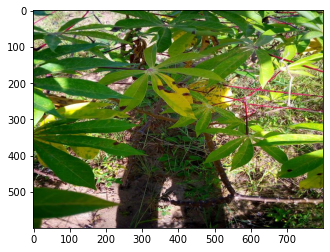

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('./data/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

In [10]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, output_label=True, one_hot_label=False, do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size'], CFG['img_size']),
                     'max_soft': True, 
                     'reformulate': False},
                 do_cutmix=False, cutmix_params={'alpha': 1,}):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size']/CFG['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size'], CFG['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size'] * CFG['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [11]:
# HueSaturationValue 값 잘못설정함 이 값은 0~255다.


from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [12]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

In [13]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [14]:
# reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [15]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        if fold > 0:
            break 

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='./data/train_images/')

        device = torch.device(CFG['device'])
        
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
17117 4280


epoch 0 loss: 0.3816: 100%|██████████| 134/134 [00:48<00:00,  2.78it/s]

validation multi-class accuracy = 0.8682



epoch 1 loss: 0.3608: 100%|██████████| 134/134 [00:46<00:00,  2.88it/s]

validation multi-class accuracy = 0.8766



epoch 2 loss: 0.3375: 100%|██████████| 134/134 [00:46<00:00,  2.88it/s]

validation multi-class accuracy = 0.8832



epoch 3 loss: 0.3359: 100%|██████████| 134/134 [00:46<00:00,  2.88it/s]

validation multi-class accuracy = 0.8818



epoch 4 loss: 0.3317: 100%|██████████| 134/134 [00:46<00:00,  2.90it/s]

validation multi-class accuracy = 0.8829



epoch 5 loss: 0.3234: 100%|██████████| 134/134 [00:46<00:00,  2.90it/s]

validation multi-class accuracy = 0.8909



epoch 6 loss: 0.3264: 100%|██████████| 134/134 [00:46<00:00,  2.90it/s]

validation multi-class accuracy = 0.8914



epoch 7 loss: 0.3244: 100%|██████████| 134/134 [00:46<00:00,  2.90it/s]

validation multi-class accuracy = 0.8857



epoch 8 loss: 0.3202: 100%|██████████| 134/134 [00:46<00:00,  2.91it/s]

validation multi-class accuracy = 0.8923



epoch 9 loss: 0.3214: 100%|██████████| 134/134 [00:46<00:00,  2.91it/s]


validation multi-class accuracy = 0.8939


In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [5]:
data_dir = './data/'
num_fold = 5
seed = 2021

train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
load_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))

Kfold = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=seed)

In [6]:
for fold, (trn_idx, val_idx) in enumerate(Kfold.split(np.arange(train.shape[0]), train.label.values)):
    print(len(trn_idx), len(val_idx))    

17117 4280
17117 4280
17118 4279
17118 4279
17118 4279


In [7]:
np.arange(train.shape[0])

array([    0,     1,     2, ..., 21394, 21395, 21396])

In [8]:
train.label.values

array([0, 3, 1, ..., 1, 4, 4])

In [9]:
for fold, (trn_idx, val_idx) in enumerate(Kfold.split(np.arange(train.shape[0]), train.label.values)):
    print(trn_idx[0:10])

[ 0  1  2  4  5  6  7  9 10 12]
[ 0  3  4  5  6  7  8  9 10 11]
[ 1  2  3  4  5  6  8  9 10 11]
[ 0  1  2  3  4  7  8 11 12 13]
[ 0  1  2  3  5  6  7  8  9 10]


In [10]:
for fold, (trn_idx, val_idx) in enumerate(Kfold.split(np.arange(train.shape[0]), train.label.values)):
    train = load_data.loc[trn_idx, :].reset_index(drop=True)
    print(train[:1])

         image_id  label
0  1000015157.jpg      0
         image_id  label
0  1000015157.jpg      0
         image_id  label
0  1000201771.jpg      3
         image_id  label
0  1000015157.jpg      0
         image_id  label
0  1000015157.jpg      0


In [18]:
train.image_id.values

array(['1000015157.jpg', '1000201771.jpg', '100042118.jpg', ...,
       '998910982.jpg', '999068805.jpg', '999998473.jpg'], dtype=object)

In [19]:
train.label.values

array([0, 3, 1, ..., 1, 3, 4])

In [12]:
data_dir = './data/train_images'
lst_input = list(os.path.join(data_dir, x) for x in train.image_id.values)

print(lst_input)

['./data/train_images/1000015157.jpg', './data/train_images/1000201771.jpg', './data/train_images/100042118.jpg', './data/train_images/1000723321.jpg', './data/train_images/1000837476.jpg', './data/train_images/1000910826.jpg', './data/train_images/1001320321.jpg', './data/train_images/1001723730.jpg', './data/train_images/1001742395.jpg', './data/train_images/1001749118.jpg', './data/train_images/100204014.jpg', './data/train_images/1002088496.jpg', './data/train_images/1002255315.jpg', './data/train_images/1002394761.jpg', './data/train_images/1003218714.jpg', './data/train_images/1003442061.jpg', './data/train_images/1003888281.jpg', './data/train_images/1003987001.jpg', './data/train_images/1004163647.jpg', './data/train_images/1004389140.jpg', './data/train_images/1004672608.jpg', './data/train_images/1004826518.jpg', './data/train_images/1004881261.jpg', './data/train_images/1005138819.jpg', './data/train_images/1005200906.jpg', './data/train_images/1005695738.jpg', './data/train

In [27]:
df = pd.read_csv('./data/train.csv')
# Kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)


In [20]:
for fold, (trn_idx, val_idx) in enumerate(Kfold.split(np.arange(load_data.shape[0]), load_data.label.values)):
    train = load_data.loc[trn_idx, :].reset_index(drop=True)
    val = load_data.loc[val_idx, :].reset_index(drop=True)
    
    print(val)

            image_id  label
0      100204014.jpg      3
1     1003218714.jpg      2
2     1003442061.jpg      4
3     1008532311.jpg      3
4     1009268848.jpg      3
...              ...    ...
2135   988174802.jpg      0
2136   991676292.jpg      3
2137   993366541.jpg      4
2138   996762577.jpg      3
2139   999998473.jpg      4

[2140 rows x 2 columns]
            image_id  label
0     1000723321.jpg      1
1     1001723730.jpg      4
2     1004163647.jpg      3
3     1007246985.jpg      3
4     1009749557.jpg      2
...              ...    ...
2135   986788190.jpg      3
2136   987098553.jpg      1
2137   990558315.jpg      3
2138    99056821.jpg      4
2139   993984792.jpg      4

[2140 rows x 2 columns]
            image_id  label
0     1002255315.jpg      3
1     1005200906.jpg      2
2      100731318.jpg      3
3     1008284502.jpg      3
4     1009049118.jpg      3
...              ...    ...
2135   997179968.jpg      3
2136   997289539.jpg      2
2137   997651546.jpg      

In [1]:
import cv2

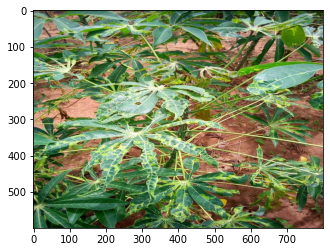

In [7]:
dir = './data/train_images/1002255315.jpg'
input = cv2.imread(dir, cv2.IMREAD_COLOR)
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

plt.imshow(input)

In [8]:
input.shape

(600, 800, 3)

In [9]:
def transform_train(im_x, im_y):
    return A.Compose([A.RandomResizedCrop(im_x, im_y),
                      A.Transpose(p=0.5),
                      A.HorizontalFlip(p=0.5),
                      A.VerticalFlip(p=0.5),
                      A.ShiftScaleRotate(p=0.5),
                      A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                      A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                      A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                      A.CoarseDropout(p=0.5), A.Cutout(p=0.5)], p=1.)

In [11]:
import albumentations as A

In [12]:
transform = transform_train(224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


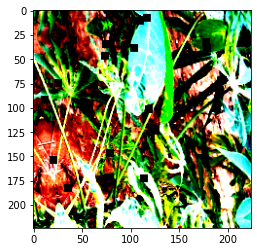

In [13]:
input=transform(image=input)['image']
plt.imshow(input)

In [14]:
print(input)

[[[ 0.67343086  1.2731092   0.931939  ]
  [-0.30268008  0.85294116  0.3742048 ]
  [-0.64517516  0.5378151   0.09533771]
  ...
  [ 0.2966863   1.3431371   0.56592596]
  [-0.26843056  0.73039216 -0.20095858]
  [-0.3369296   0.64285713 -0.20095858]]

 [[ 0.34806055  1.0980392   0.75764704]
  [-0.25130582  0.7478991   0.3742048 ]
  [-0.57667613  0.4152661   0.06047932]
  ...
  [ 0.36518532  1.3081232   0.6007843 ]
  [-0.16568205  0.80042017 -0.06152503]
  [-0.4054286   0.6078431  -0.23581697]]

 [[ 0.07406451  0.97549015  0.6007843 ]
  [-0.3369296   0.64285713  0.32191724]
  [-0.5938009   0.2927171   0.02562094]
  ...
  [ 0.39943483  1.3256302   0.70535946]
  [ 0.00556549  0.92296916  0.18248367]
  [-0.31980482  0.6078431  -0.148671  ]]

 ...

 [[-0.6280504  -0.35504198 -0.8458387 ]
  [-0.6109256  -0.21498597 -0.776122  ]
  [-0.64517516 -0.16246496 -0.74126357]
  ...
  [ 0.2624368   1.2205882   1.1585186 ]
  [ 0.38231006  1.3256302   1.2456645 ]
  [ 0.43368432  1.3781512   1.297952  ]]

 [

In [15]:
input.shape

(224, 224, 3)

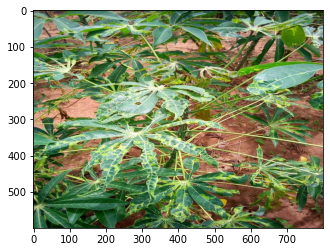

In [16]:
dir = './data/train_images/1002255315.jpg'
input = cv2.imread(dir, cv2.IMREAD_COLOR)
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

plt.imshow(input)

In [17]:
input.shape

(600, 800, 3)

In [18]:
if input.ndim == 2:
    input = input[:, :, np.newaxis]
    
input.shape

(600, 800, 3)

In [19]:
input = np.moveaxis(input[:, :, :], -1, 0)
input.shape

(3, 600, 800)

In [25]:
def rand_bbox(img_x, img_y, lam):
    W = img_x
    H = img_y
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix_data(input, label, cutmix, df, data_dir, img_x, img_y):
    if cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
        with torch.no_grad():
            cmix_idx = np.random.choice(df.index, size=1)[0]
            cmix_img = os.path.join(data_dir, df.iloc[cmix_idx]['image_id'])

            lam = np.clip(np.random.beta(1,1), 0.3, 0.4)
            bbx1, bby1, bbx2, bby2 = rand_bbox(img_x, img_y, lam)

            input[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

            rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img_x * img_y))
            label = rate * label + (1. - rate) * label[cmix_idx]

        return input, label

In [28]:
transform=cutmix_data(True, df, './data', 224, 224 )

TypeError: cutmix_data() missing 2 required positional arguments: 'img_x' and 'img_y'

In [30]:
a = True
b = 1 if not a else 2

print(b)

2
